In [1]:
import os
import random
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import xml.etree.ElementTree as ET
import cv2 as cv

import warnings
warnings.filterwarnings("ignore")

# 1. Подготовка датасета для обучения yolo комплектными средствами

In [2]:
class FaceMaskDataset(torch.utils.data.Dataset):
    """
        Dataset for mask dataset: https://www.kaggle.com/datasets/andrewmvd/face-mask-detection
        
        Args:
            root (str): Path of dataset on local
            transforms (transforms.Compose, optional): Transforms functions, witch take (img, target), modify they and return new (img, target)
            slice_vals (touple(int, int), optional): How shuffle dataset would be cut. For example, (0, 0.8) - take first 80% of dataset.
    """
    def __init__(self, root, transforms = None, slice_vals = None):
        
        self.root = root
        self.transforms = transforms
        # Get annotations_list
        annotations_path = list(sorted(os.listdir(os.path.join(root, "annotations"))))
        # Cut annotations_list by slice_vals
        if slice_vals:
            size = len(annotations_path)
            random.seed(42)
            random.shuffle(annotations_path)
            annotations_path = annotations_path[int(size*slice_vals[0]) : int(size*slice_vals[1])]
        annotations = [self.__xml_to_dict(os.path.join(self.root, "annotations", path)) for path in annotations_path]
        # Get targets
        self.targets = []
        for idx, annotation in enumerate(annotations):
            boxes = annotation["bndboxes"]
            labels = annotation["labels"]
            # convert everything into a torch.Tensor
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.as_tensor(labels, dtype=torch.uint8)

            image_id = torch.tensor([idx])
            target = {}
            target["boxes"] = boxes
            target["labels"] = labels
            target["image_id"] = image_id
            self.targets.append(target)
        # Get images
        self.images = []
        for img_path in [os.path.join(self.root, annotation["image_path"]) for annotation in annotations]:
            img = cv.imread(img_path)
            img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
            img = np.array(img)
            self.images.append(img)
            
            
    def __getitem__(self, idx):
        # load images and masks
        img = self.images[idx].copy()
        target = dict(self.targets[idx])
        
        if self.transforms is not None:
            img, target = self.transforms((img, target))

        return img, target

    def __len__(self):
        return len(self.targets)
    
    def __xml_to_dict(self, xml_file_path: str):
        """Parse .xml file in the xml_file_path, and return annotation with 
        "bndboxes": (x_cent,y_cent,width,height), "labels": (class), for each boxes in .xml file
        and "image_path" with target images.
        """ 
        class_mapping = {'with_mask' : 1,
                         'without_mask' : 0,
                         'mask_weared_incorrect' : 0}

        tree = ET.parse(xml_file_path)
        root = tree.getroot()

        output = {}
        output["image_path"] = os.path.join(root.find("folder").text, root.find("filename").text)
        width, height = int(root.find('size')[0].text), int(root.find("size")[1].text)
        output["labels"] = []
        output["bndboxes"] = []
        for member in root.findall("object"):
            output["labels"].append(class_mapping.get(member[0].text))

            bndbox = [float(elem.text) for elem in member.find("bndbox")]
            bndbox_convert = self.__convert((width, height), bndbox)
            output["bndboxes"].append(bndbox_convert)

        return output
    
    def __convert(self, size: tuple, box: list):
        """Takes as input:  (width, height) of an image
                            (xmin, ymin, xmax, ymax) of the bounding box
           and returns (x_cent, y_cent, w, h) of the bounding box in yolo format.
        """   
        dw = 1./size[0]
        dh = 1./size[1]
        x = (box[2] + box[0])/2.0
        y = (box[3] + box[1])/2.0
        w = abs(box[2] - box[0])
        h = abs(box[3] - box[1])
        x = x*dw
        w = w*dw
        y = y*dh
        h = h*dh

        return (x, y, w, h)
    
    def save(self, save_path, dataset_type):
        """Save dataset to save_path to dataset_type directory"""
        len_dataset = len(self)
        image_path = os.path.join(save_path, "images", dataset_type)
        labels_path = os.path.join(save_path, "labels", dataset_type)
        os.makedirs(image_path, exist_ok=True)
        os.makedirs(labels_path, exist_ok=True)
        
        for i in range(len_dataset):
            img, target = self[i]
            
            if isinstance(img, torch.Tensor):
                img = img.numpy().transpose((1, 2, 0)).copy()
            img = cv.cvtColor(img, cv.COLOR_RGB2BGR)
            cv.imwrite(os.path.join(image_path, str(i)+".png"), img)
            
            labels = torch.cat((target["labels"].reshape((-1, 1)), target["boxes"]), dim=1).numpy()
            with open(os.path.join(labels_path, str(i)+".txt"), 'w') as output:
                for row in labels:
                    output.write("\t".join(row.astype(str)) + '\n')
            

Разбиваем датасет на train, valid и test

In [3]:
train_dataset = FaceMaskDataset("../dataset",slice_vals=(0.0, 0.8))
valid_dataset = FaceMaskDataset("../dataset", slice_vals=(0.8, 0.95))
test_dataset = FaceMaskDataset("../dataset", slice_vals=(0.95, 1))

Сохраняем датасеты

In [4]:
train_dataset.save('../datasets/mask_dataset','train')
valid_dataset.save('../datasets/mask_dataset','valid')
test_dataset.save('../datasets/mask_dataset','test')

# 2. Производим обучение yolov5 штатными средствами

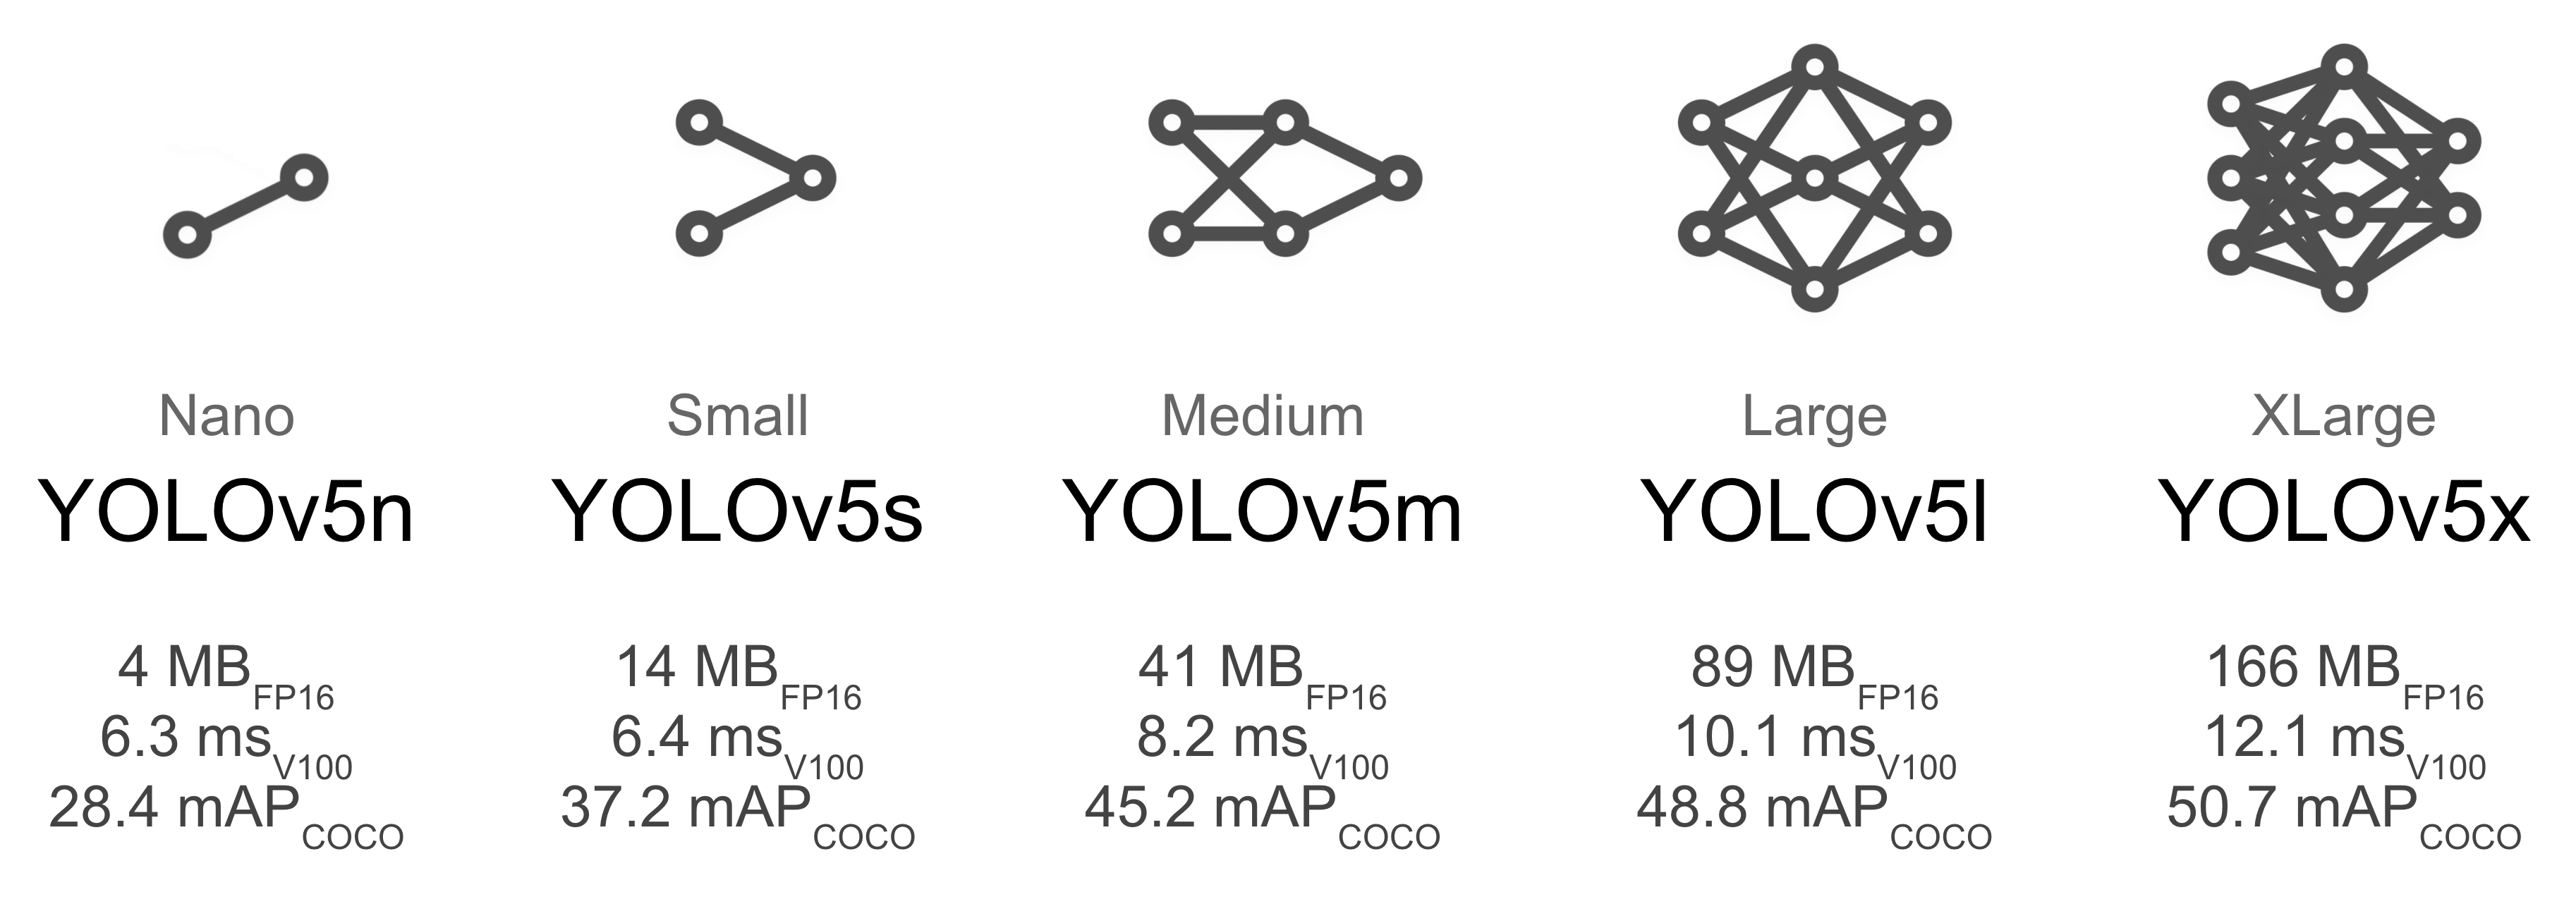

Для обучения выберим версию yolov5 с приставкой s, т.к. она является достаточно небольшой (чтобы уместиться в ограниченные 4gb видеопамяти), но и в тоже время и достаточно мощной, чтобы решить поставленную задачу

Обучим yolo без заморозки слоёв (количество эпох было заменено с 200 на 1, чтобы продемонстрировать, как выглядит процес обучения)

In [1]:
%run ../yolov5/train.py --img 640 --batch 8 --epochs 1 --data ../data/mask_dataset.yaml --weights ../data/weights/yolov5s.pt --optimizer Adam --name full_model_unfreeze

train: weights=../data/weights/yolov5s.pt, cfg=, data=../data/mask_dataset.yaml, hyp=..\yolov5\data\hyps\hyp.scratch-low.yaml, epochs=1, batch_size=8, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=Adam, sync_bn=False, workers=8, project=..\yolov5\runs\train, name=full_model_unfreeze, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest


github: skipping check (not a git repository), for updates see https://github.com/ultralytics/yolov5


YOLOv5  b9c498d torch 1.10.2 CUDA:0 (NVIDIA GeForce GTX 1050 Ti, 4096MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degrees=0.0, translate=0.1, scale=0.5, shear=0.0, perspective=0.0, flipud=0.0, fliplr=0.5, mosaic=1.0, mixup=0.0, copy_paste=0.0
TensorBoard: Start with 'tensorboard --logdir ..\yolov5\runs\train', view at http://localhost:6006/
Overriding model.yaml nc=80 with nc=2

                 from  n    params  module                                  arguments                     
  0                -1  1      3520  models.common.Conv                      [3, 32, 6, 2, 2]              
  1                -1  1     18560  models.common.Conv                      [32, 64, 3, 2]                
  2                -1  1     18816  models.common.C3                        

Weights & Biases: run 'pip install wandb' to automatically track and visualize YOLOv5  runs (RECOMMENDED)



Transferred 343/349 items from ..\data\weights\yolov5s.pt
Scaled weight_decay = 0.0005
optimizer: Adam with parameter groups 57 weight (no decay), 60 weight, 60 bias
train: Scanning 'C:\Users\Domni\Desktop\MaskProgect\datasets\mask_dataset\labels\train.cache' images and labels... 682 
val: Scanning 'C:\Users\Domni\Desktop\MaskProgect\datasets\mask_dataset\labels\valid' images and labels...128 found, 0 
val: New cache created: C:\Users\Domni\Desktop\MaskProgect\datasets\mask_dataset\labels\valid.cache


module 'signal' has no attribute 'SIGALRM'



AutoAnchor: 5.55 anchors/target, 0.999 Best Possible Recall (BPR). Current anchors are a good fit to dataset 
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to ..\yolov5\runs\train\full_model_unfreeze
Starting training for 1 epochs...

     Epoch   gpu_mem       box       obj       cls    labels  img_size


['without mask', 'with mask']


       0/0     1.96G   0.07399   0.05118   0.01802        16       640: 100%|██████████| 86/86 [01:15<00:00,  1.14it/s]
               Class     Images     Labels          P          R     mAP@.5 mAP@.5:.95: 100%|██████████| 8/8 [00:02<00:
                 all        128        578      0.552      0.152     0.0417    0.00751

1 epochs completed in 0.022 hours.
Optimizer stripped from ..\yolov5\runs\train\full_model_unfreeze\weights\last.pt, 14.4MB
Optimizer stripped from ..\yolov5\runs\train\full_model_unfreeze\weights\best.pt, 14.4MB

Validating ..\yolov5\runs\train\full_model_unfreeze\weights\best.pt...
Fusing layers... 
Model Summary: 213 layers, 7015519 parameters, 0 gradients
               Class     Images     Labels          P          R     mAP@.5 mAP@.5:.95: 100%|██████████| 8/8 [00:16<00:
                 all        128        578      0.553      0.143     0.0417    0.00754
        without mask        128        104          1          0     0.0255    0.00395
           with 

Обучим yolo c заморозкой backbone слоёв

In [1]:
%run ../yolov5/train.py --img 640 --batch 8 --epochs 1 --data ../data/mask_dataset.yaml --weights ../data/weights/yolov5s.pt --optimizer Adam --freeze 11 --name backbone_freeze 

train: weights=../data/weights/yolov5s.pt, cfg=, data=../data/mask_dataset.yaml, hyp=..\yolov5\data\hyps\hyp.scratch-low.yaml, epochs=1, batch_size=8, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=Adam, sync_bn=False, workers=8, project=..\yolov5\runs\train, name=backbone_freeze, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[11], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest


github: skipping check (not a git repository), for updates see https://github.com/ultralytics/yolov5


YOLOv5  b9c498d torch 1.10.2 CUDA:0 (NVIDIA GeForce GTX 1050 Ti, 4096MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degrees=0.0, translate=0.1, scale=0.5, shear=0.0, perspective=0.0, flipud=0.0, fliplr=0.5, mosaic=1.0, mixup=0.0, copy_paste=0.0
TensorBoard: Start with 'tensorboard --logdir ..\yolov5\runs\train', view at http://localhost:6006/
Overriding model.yaml nc=80 with nc=2

                 from  n    params  module                                  arguments                     
  0                -1  1      3520  models.common.Conv                      [3, 32, 6, 2, 2]              
  1                -1  1     18560  models.common.Conv                      [32, 64, 3, 2]                
  2                -1  1     18816  models.common.C3                        

Weights & Biases: run 'pip install wandb' to automatically track and visualize YOLOv5  runs (RECOMMENDED)


Model Summary: 270 layers, 7025023 parameters, 7025023 gradients

Transferred 343/349 items from ..\data\weights\yolov5s.pt
freezing model.0.conv.weight
freezing model.0.bn.weight
freezing model.0.bn.bias
freezing model.1.conv.weight
freezing model.1.bn.weight
freezing model.1.bn.bias
freezing model.2.cv1.conv.weight
freezing model.2.cv1.bn.weight
freezing model.2.cv1.bn.bias
freezing model.2.cv2.conv.weight
freezing model.2.cv2.bn.weight
freezing model.2.cv2.bn.bias
freezing model.2.cv3.conv.weight
freezing model.2.cv3.bn.weight
freezing model.2.cv3.bn.bias
freezing model.2.m.0.cv1.conv.weight
freezing model.2.m.0.cv1.bn.weight
freezing model.2.m.0.cv1.bn.bias
freezing model.2.m.0.cv2.conv.weight
freezing model.2.m.0.cv2.bn.weight
freezing model.2.m.0.cv2.bn.bias
freezing model.3.conv.weight
freezing model.3.bn.weight
freezing model.3.bn.bias
freezing model.4.cv1.conv.weight
freezing model.4.cv1.bn.weight
freezing model.4.cv1.bn.bias
freezing model.4.cv2.conv.weight
freezing model.4.c

module 'signal' has no attribute 'SIGALRM'


Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to ..\yolov5\runs\train\backbone_freeze2
Starting training for 1 epochs...

     Epoch   gpu_mem       box       obj       cls    labels  img_size


['without mask', 'with mask']


       0/0    0.705G   0.07283   0.05075   0.01801        16       640: 100%|██████████| 86/86 [00:28<00:00,  3.05it/s]
               Class     Images     Labels          P          R     mAP@.5 mAP@.5:.95: 100%|██████████| 8/8 [00:02<00:
                 all        128        578      0.204       0.62      0.132     0.0295

1 epochs completed in 0.009 hours.
Optimizer stripped from ..\yolov5\runs\train\backbone_freeze2\weights\last.pt, 14.4MB
Optimizer stripped from ..\yolov5\runs\train\backbone_freeze2\weights\best.pt, 14.4MB

Validating ..\yolov5\runs\train\backbone_freeze2\weights\best.pt...
Fusing layers... 
Model Summary: 213 layers, 7015519 parameters, 0 gradients
               Class     Images     Labels          P          R     mAP@.5 mAP@.5:.95: 100%|██████████| 8/8 [00:23<00:
                 all        128        578      0.199      0.621      0.134     0.0299
        without mask        128        104      0.371      0.279      0.169     0.0407
           with mask     

Обучим yolo c заморозкой всех слоёв, кроме слоёв детектора

In [1]:
%run ../yolov5/train.py --img 640 --batch 8 --epochs 1 --data ../data/mask_dataset.yaml --weights ../data/weights/yolov5s.pt --optimizer Adam --freeze 24 --name only_detector_unfreeze 

train: weights=../data/weights/yolov5s.pt, cfg=, data=../data/mask_dataset.yaml, hyp=..\yolov5\data\hyps\hyp.scratch-low.yaml, epochs=1, batch_size=8, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=Adam, sync_bn=False, workers=8, project=..\yolov5\runs\train, name=only_detector_unfreeze, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[24], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest


github: skipping check (not a git repository), for updates see https://github.com/ultralytics/yolov5


YOLOv5  b9c498d torch 1.10.2 CUDA:0 (NVIDIA GeForce GTX 1050 Ti, 4096MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degrees=0.0, translate=0.1, scale=0.5, shear=0.0, perspective=0.0, flipud=0.0, fliplr=0.5, mosaic=1.0, mixup=0.0, copy_paste=0.0
TensorBoard: Start with 'tensorboard --logdir ..\yolov5\runs\train', view at http://localhost:6006/
Overriding model.yaml nc=80 with nc=2

                 from  n    params  module                                  arguments                     
  0                -1  1      3520  models.common.Conv                      [3, 32, 6, 2, 2]              
  1                -1  1     18560  models.common.Conv                      [32, 64, 3, 2]                
  2                -1  1     18816  models.common.C3                        

Weights & Biases: run 'pip install wandb' to automatically track and visualize YOLOv5  runs (RECOMMENDED)



Transferred 343/349 items from ..\data\weights\yolov5s.pt
freezing model.0.conv.weight
freezing model.0.bn.weight
freezing model.0.bn.bias
freezing model.1.conv.weight
freezing model.1.bn.weight
freezing model.1.bn.bias
freezing model.2.cv1.conv.weight
freezing model.2.cv1.bn.weight
freezing model.2.cv1.bn.bias
freezing model.2.cv2.conv.weight
freezing model.2.cv2.bn.weight
freezing model.2.cv2.bn.bias
freezing model.2.cv3.conv.weight
freezing model.2.cv3.bn.weight
freezing model.2.cv3.bn.bias
freezing model.2.m.0.cv1.conv.weight
freezing model.2.m.0.cv1.bn.weight
freezing model.2.m.0.cv1.bn.bias
freezing model.2.m.0.cv2.conv.weight
freezing model.2.m.0.cv2.bn.weight
freezing model.2.m.0.cv2.bn.bias
freezing model.3.conv.weight
freezing model.3.bn.weight
freezing model.3.bn.bias
freezing model.4.cv1.conv.weight
freezing model.4.cv1.bn.weight
freezing model.4.cv1.bn.bias
freezing model.4.cv2.conv.weight
freezing model.4.cv2.bn.weight
freezing model.4.cv2.bn.bias
freezing model.4.cv3.co

module 'signal' has no attribute 'SIGALRM'



AutoAnchor: 5.55 anchors/target, 0.999 Best Possible Recall (BPR). Current anchors are a good fit to dataset 
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to ..\yolov5\runs\train\only_detector_unfreeze3
Starting training for 1 epochs...

     Epoch   gpu_mem       box       obj       cls    labels  img_size


['without mask', 'with mask']


       0/0    0.317G    0.1009   0.05924   0.01883        16       640: 100%|██████████| 86/86 [00:17<00:00,  4.80it/s]
               Class     Images     Labels          P          R     mAP@.5 mAP@.5:.95: 100%|██████████| 8/8 [00:02<00:
                 all        128        578     0.0596      0.157     0.0401    0.00822

1 epochs completed in 0.006 hours.
Optimizer stripped from ..\yolov5\runs\train\only_detector_unfreeze3\weights\last.pt, 14.4MB
Optimizer stripped from ..\yolov5\runs\train\only_detector_unfreeze3\weights\best.pt, 14.4MB

Validating ..\yolov5\runs\train\only_detector_unfreeze3\weights\best.pt...
Fusing layers... 
Model Summary: 213 layers, 7015519 parameters, 0 gradients
               Class     Images     Labels          P          R     mAP@.5 mAP@.5:.95: 100%|██████████| 8/8 [00:03<00:
                 all        128        578     0.0596      0.157     0.0401    0.00819
        without mask        128        104     0.0463     0.0385    0.00687    0.00204
    

# 3. Сравнение результатов работы сети

Для сравнения результатов обучения можно воспользоваться tensorboard

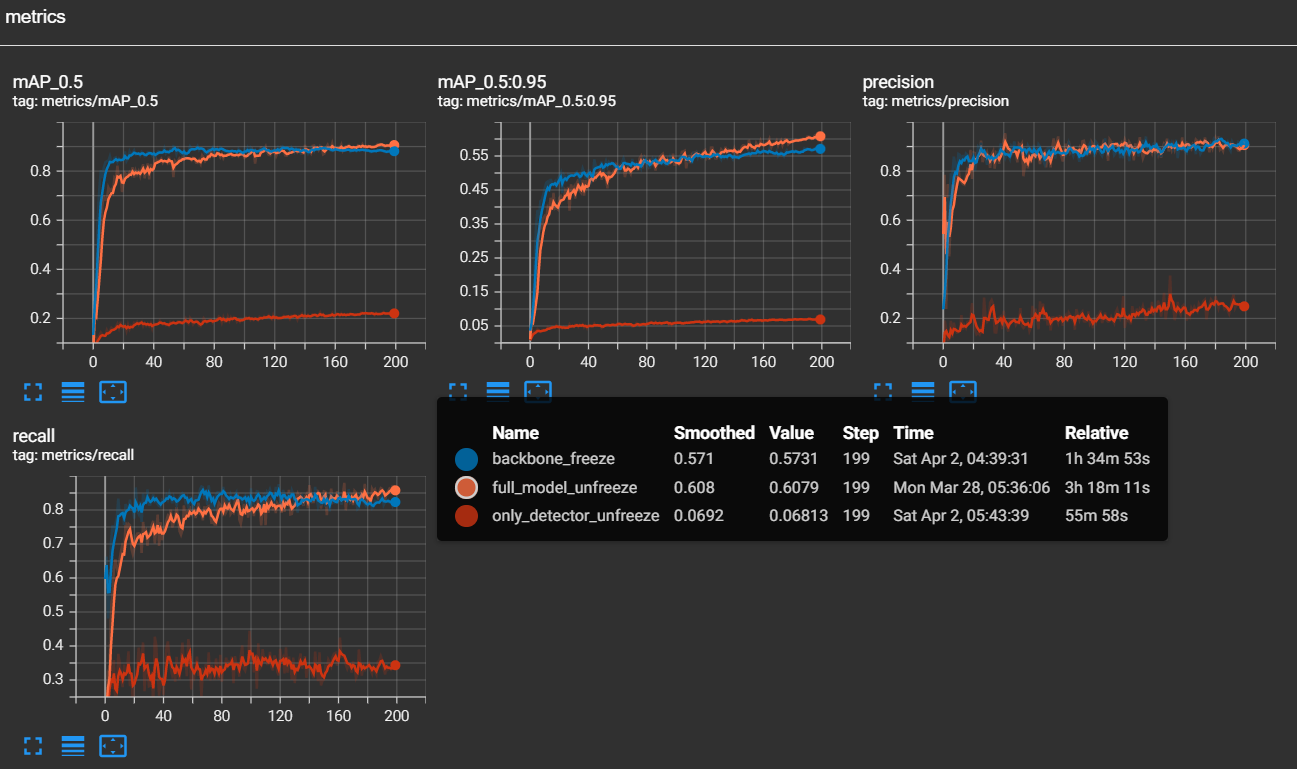

Как видно из метрик, лучше всего себя показывает модель, у которой разморожены все слои.

Результат лучшей модели показан в следующей ячейки

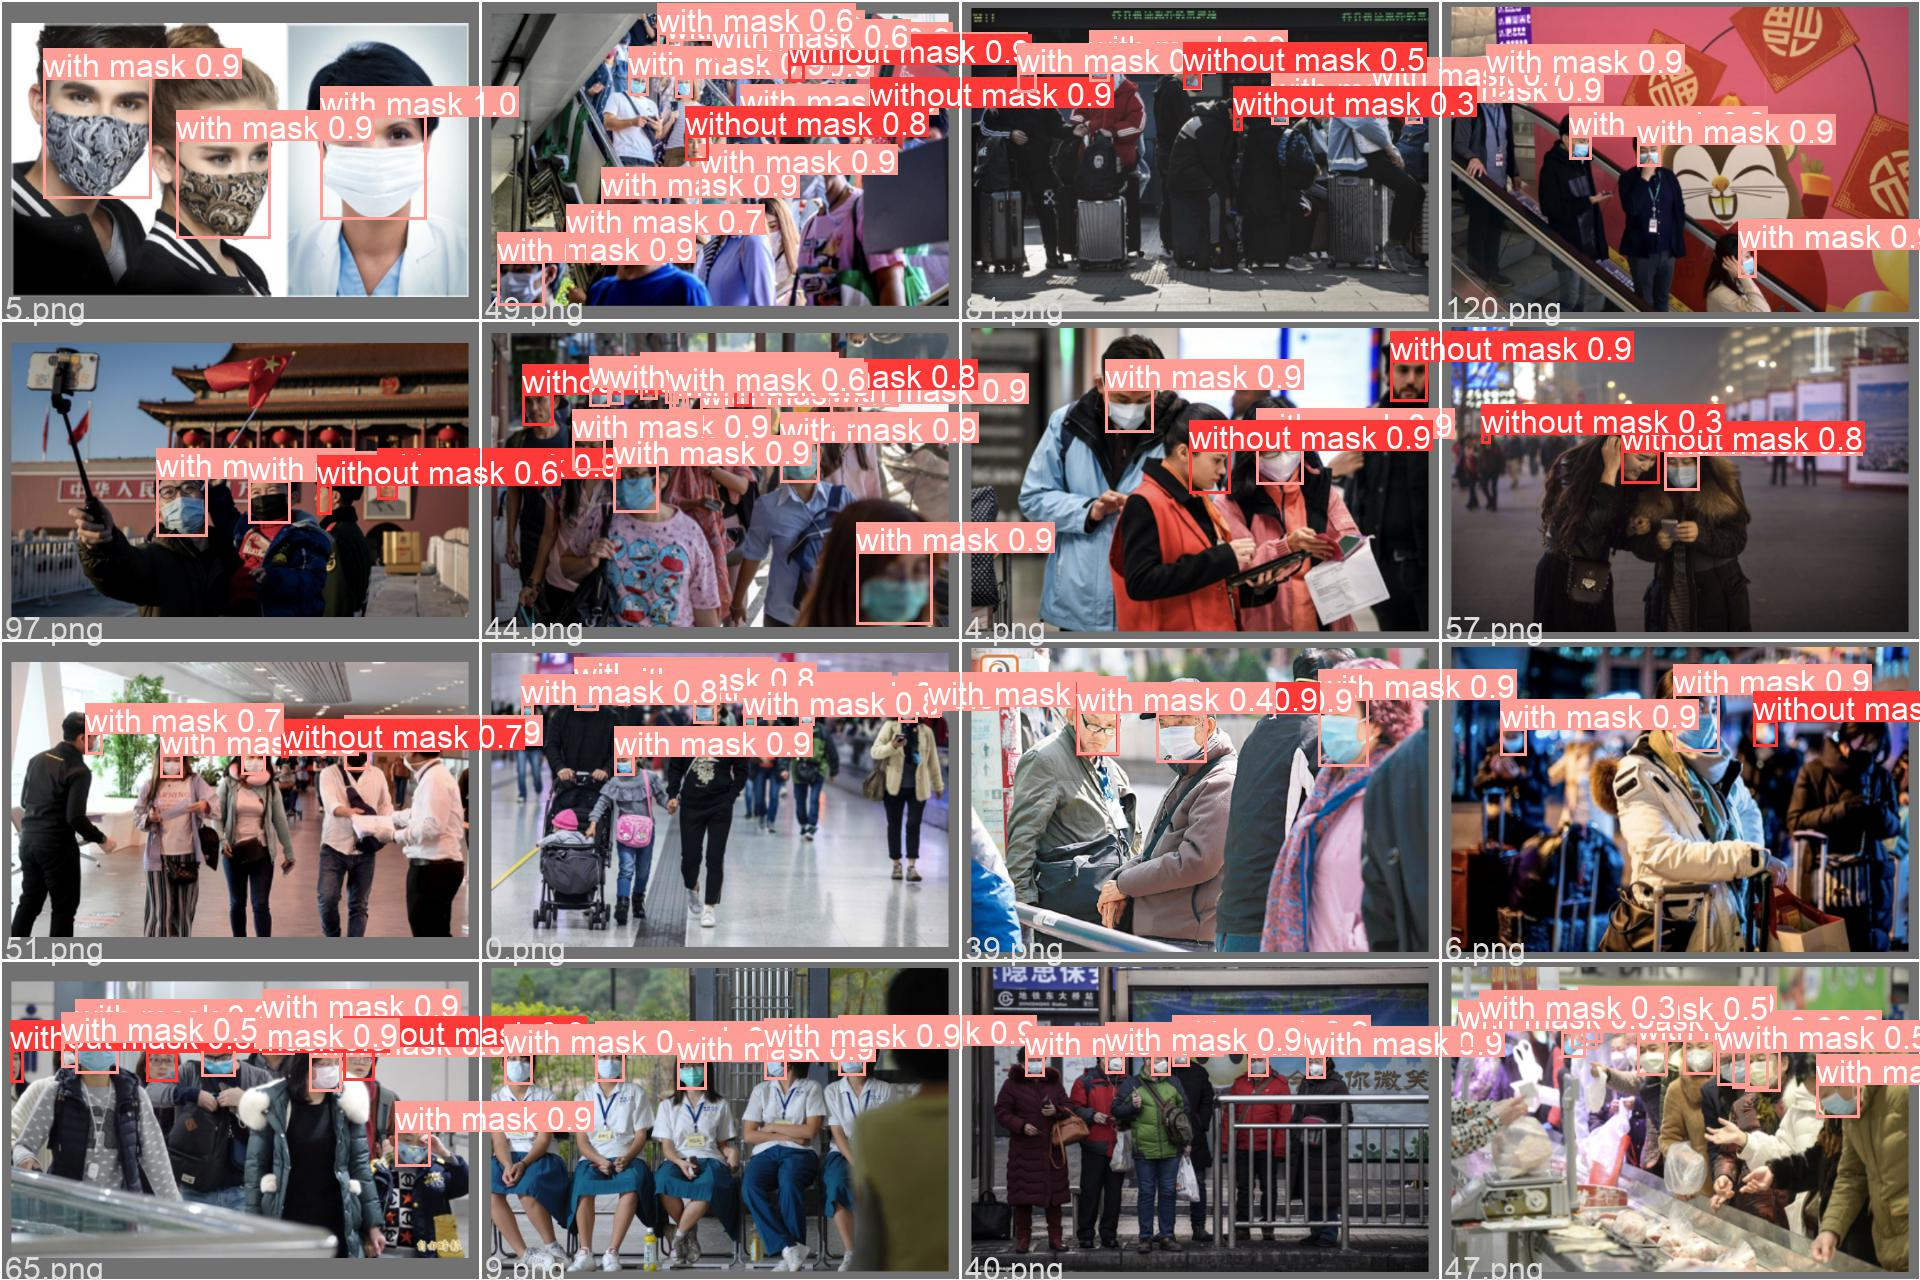

Как видно из набора изображений, модель в целом справляется очень даже неплохо. 
Расположение боксов определяет достаточно точно (даже на изображении 57 она нашла микроскопическое лицо). Классификатор в большинстве примеров работает правильно, но, чем меньше лицо, тем хуже оно работает. В связи с этим на изображении 81 видно, как модель называет человека в маске как того, кто без маски. А на изображении 39, если приглядеться, модель для самого левого мужчины определила 2 бокса - что он в маске, и что он без маски одновременно. Возможно, очки, надетые на человека, сильно ухудшают предсказание модели.   

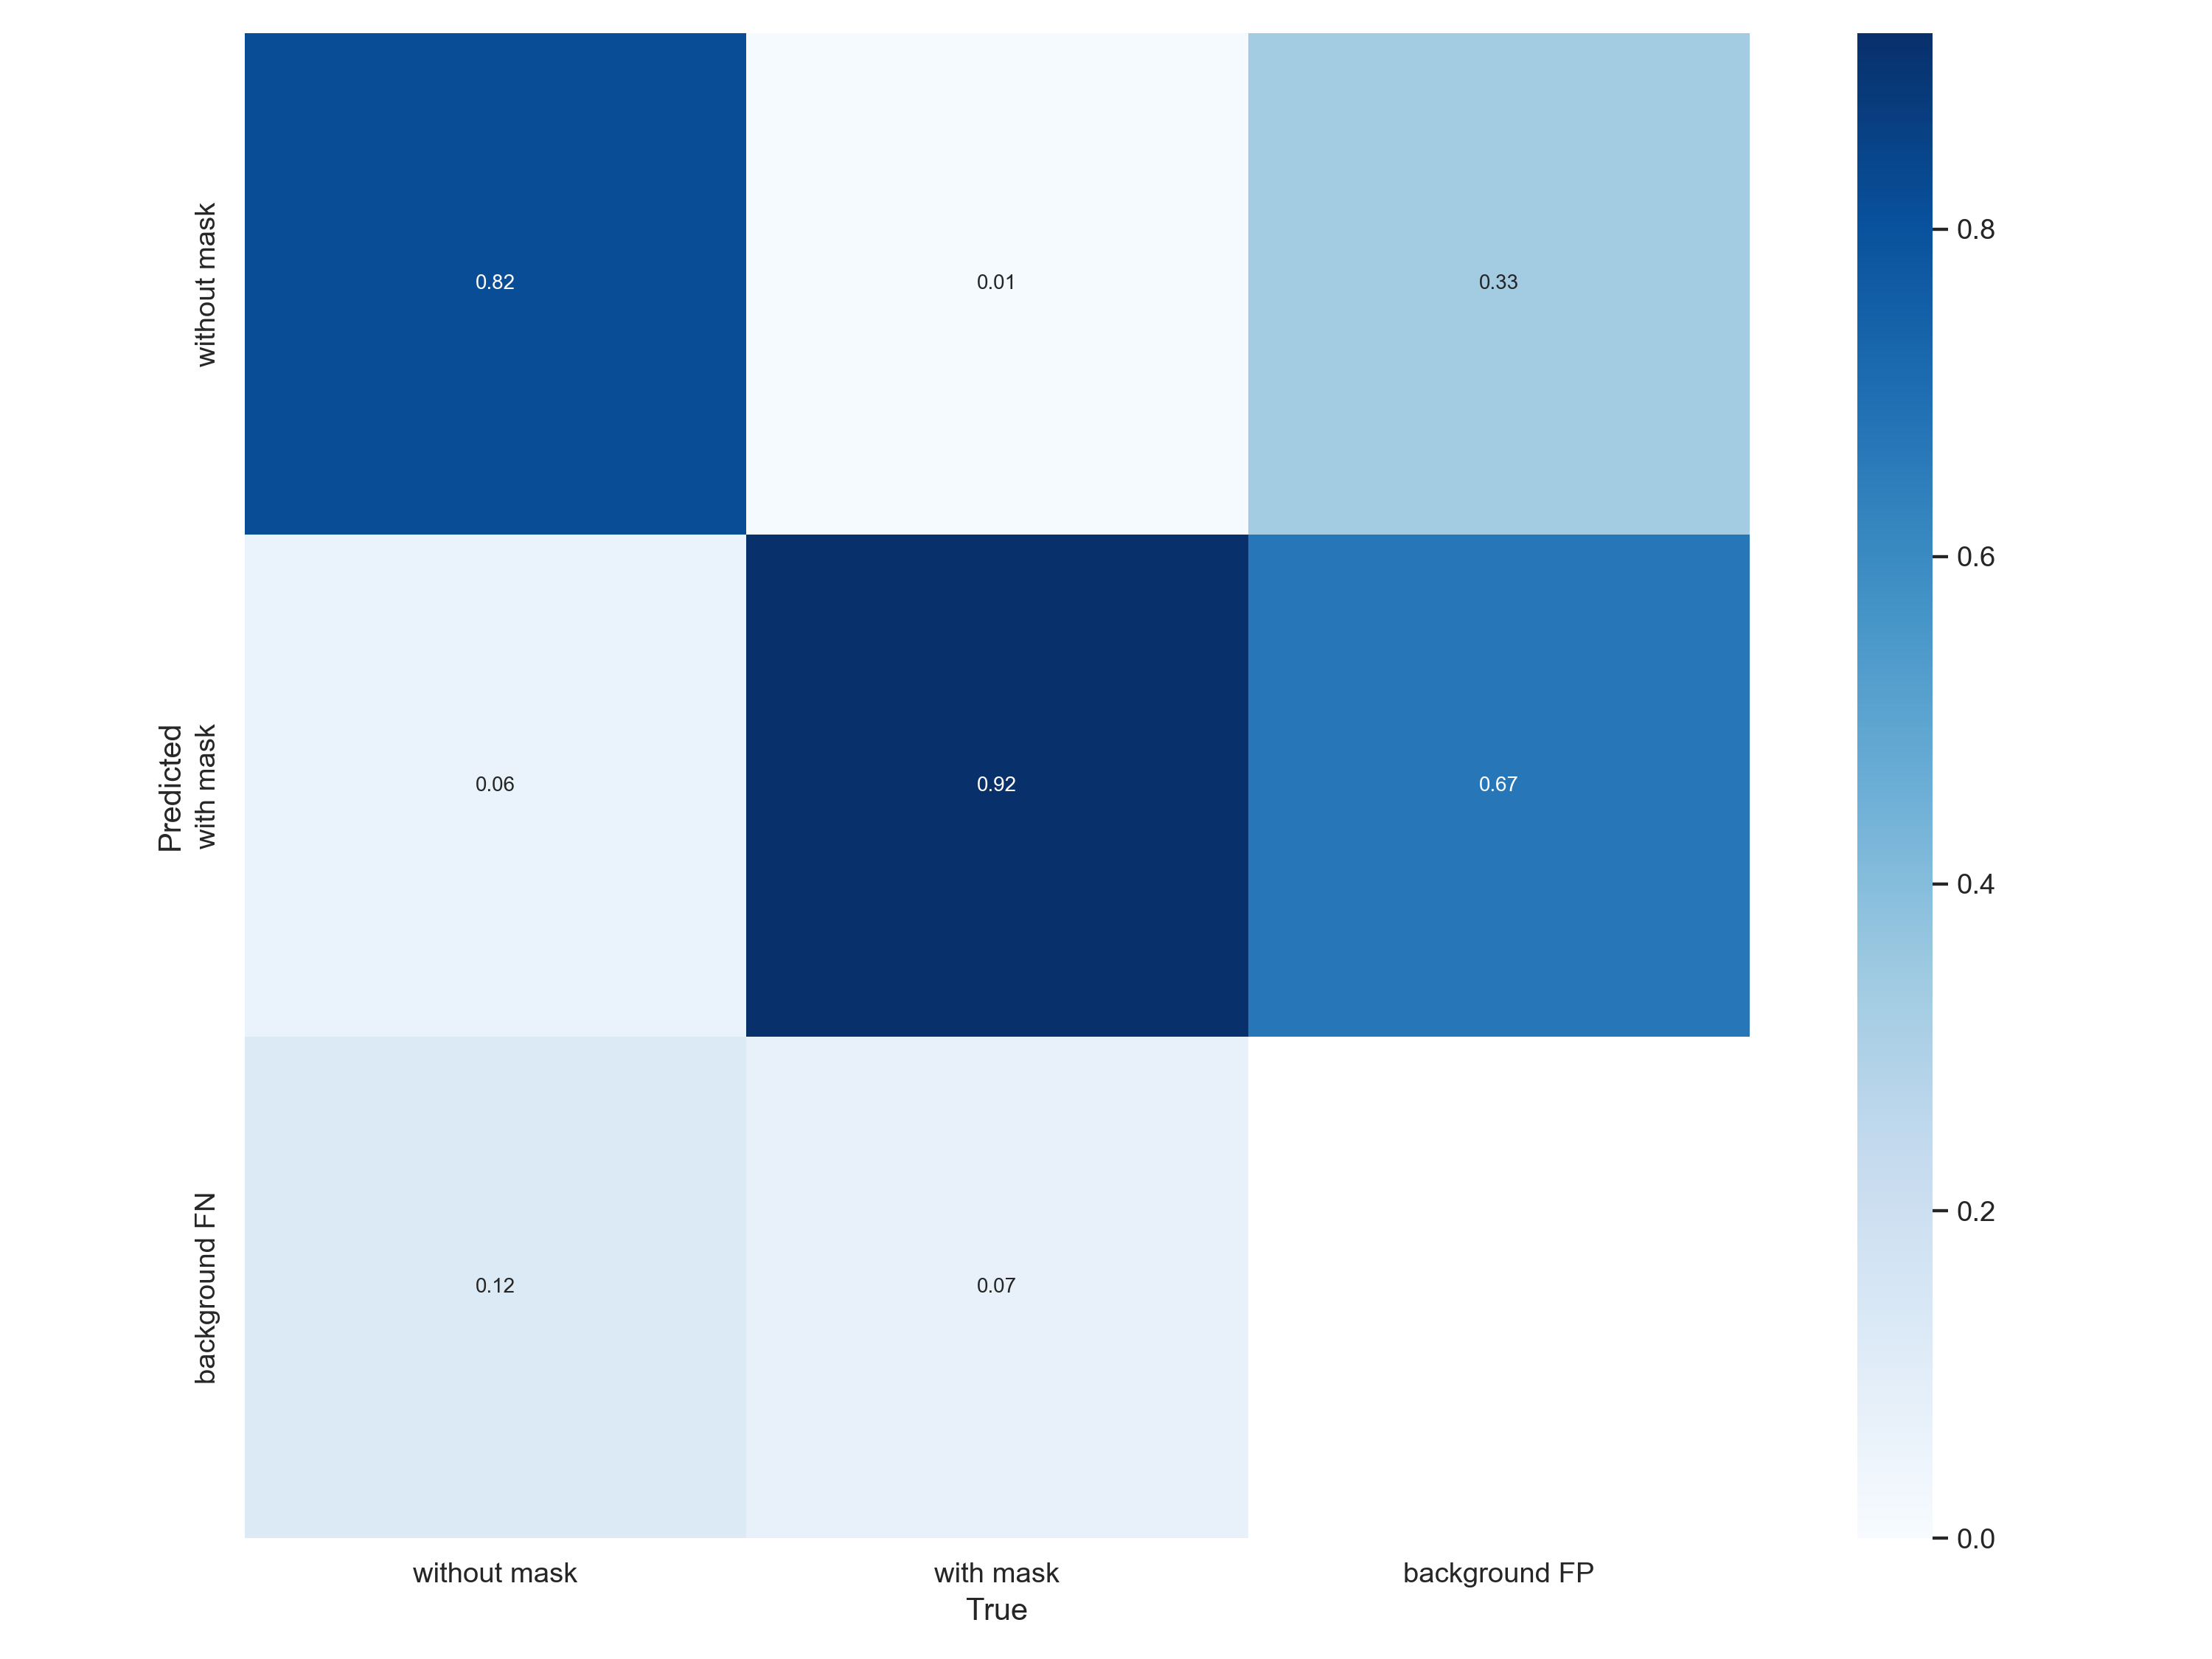

Если взглянуть на confusion matrix, то можно заметить, что модель в целом неплохо справляется с предсказанием. В данном случае значения в столбце background на первый взляд выглядет некорректными, но если присмотреться, то можно понять, что данный столбец для нас является мусорными, т.к. в датасете нет класса background, соответсвенно и некорректно высчитывать, как часто мы его путаем с другими классами.

# 4. Вывод 

Данное иследование показало, что самым лучшим способом обучать модель является обучение с полной разморозкой всех слоёв.
В дальнейшем, данную нейросеть планируется обучить на больших количествах эпох (т.к. loss всё ещё падает).